<a id='qaoa-workflow-demo'></a>

# First steps: An example workflow of the QAOA package

This notebook walks through a simple example workflow, and is intended as a quick introduction to the functionalities of the package. More elaborate examples are provided in the following notebooks.

## Discussion:
 - The arguments `nshots` and `scalar_cost_function` default to `0` and `True` respectively, so they don't have to be passed explicitely. Do we pass them anyways, to indicate to the user that there are some more options, or do we remove them to get shorter and easier to understand code?
 - The argument `sim` is not neccesary anymore, if it is not passed `QAOACostFunctionOnWFSim` simply gets its own simulator connection. So the same question arises here again.
 - I found, that `Nelder-Mead` (the default for scipy.optimize.minimize) gets stuck in local minima quite often (at least with) the examples in `AdvancedQAOAParameterDemo` and I needed to pass `method="Cobyla"` often. Do we go with `Nelder-Mead` anyways, because the correct choice of an optimizer is a question that is more appropriate for the more advanced Notebooks?
 - Check the imports, that we really only import things we are actually using later.

## Contents
1. [Creating the problem instance](#creating_a_hamiltonian)
2. [Setting up the parameters](#setup_parameters)
3. [Creating a cost function](#cost_function)
4. [Optimising the paramters](#optimisation)
5. [Outlook: Playing with the parameters](#outlook)

As with all the Demo Notebooks, you need to start the Wavefunction Simulator and the Quil Compiler in the background by typing `qvm -S` and `quilc -S` in two open and disposable terminal windows.  If you have installed the Forest SDK, the Quantum Virtual Machine will start in the background. More information on installing and running the QVM can be found in Rigetti's __[Forest documentation](http://docs.rigetti.com/en/stable/start.html)__. 

Before we really start, let us import all the neccesary bits and pieces:

In [1]:
# The usual combination of numpy, matplotlib and scipy.optimize.minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# The neccesary pyquil modules
from pyquil.api import local_qvm, WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.unitary_tools import lifted_pauli

# The QAOAParameters that we want to demo
from entropica_qaoa.qaoa.parameters import (AbstractParams,
                                            StandardParams,
                                            ExtendedParams,
                                            QAOAParameterIterator)

# import VQE and cost function modules
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnQVM, QAOACostFunctionOnWFSim

# import utilities for conversion between graphs and hamiltonians
from entropica_qaoa.utilities import (hamiltonian_from_graph,
                                      random_k_regular_graph,
                                      plot_graph,
                                      plot_amplitudes)

# supress warnings from networkx
import warnings
warnings.filterwarnings('ignore')

<a id='creating_a_hamiltonian'></a>

## Creating the problem instance

Before we can demonstate QAOA, we first need a problem to solve. As an example we will demonstrate how to use QAOA to solve the MaxCut problem on a graph with three nodes and weighted edges. Let us first create the graph:

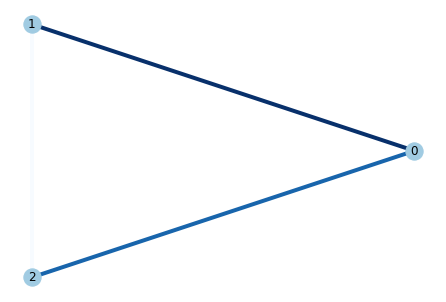

In [2]:
graph = random_k_regular_graph(degree=2, nodes=3, seed=42, weighted=True, biases=True)
plot_graph(graph)

Now, our QAOA implementation doesn't solve the MaxCut problem on a graph directly. Instead we have to translate the graph to a hamiltonian using `hamiltonian_from_graph`.

In [3]:
hamiltonian = hamiltonian_from_graph(graph)
print(hamiltonian)

(0.31871959185209275+0j)*Z0 + (0.7293497456610921+0j)*Z1 + (0.2729959206343987+0j)*Z2 + (0.6836709185522297+0j)*Z0*Z1 + (0.5976518295147031+0j)*Z0*Z2 + (0.26151215504191927+0j)*Z1*Z2



**Further documentation**

We go into more detail about the creation of hamiltonians and graphs in `UtilitiesDemo.ipynb`.

<a id='setup_parameters'></a>

## Specify the variable parameters and create corresponding `QAOAParameters` object

After creation of the problem hamiltonian we need to setup the variable parameters that are later optimised to find the best cut. To facilitate the usage of many different parametrisations of the QAOA circuit we use cost `QAOAParameter` objects instead of simple arrays or lists. For this Notebook we will use the `StandardParams` parametrisation—this corresponds to the parametrisation of the original QAOA paper by Farhi et al, where the mixer and cost Hamiltonian each have one angle per timestep (giving a total of 2p parameters to optimise over).

We will choose $p=2$ for now and just write down any `gammas` and `betas` as the initial parameters, they will get optimised later! Besides the initial `gammas` and `betas`–the parameters that get optimized later–our `QAOAParameter` classes also need to know the problem hamiltonian and the number of timesteps `p`–the hyperparameters that don't get changed during the QAOA optimisation.

In [4]:
timesteps = 2 # this is the p value from the original paper
hyperparameters = (hamiltonian, timesteps)

# Specify some angles. We have p=2, so we need two betas and two gammas
betas = [0.1, 0.6]
gammas = [0.4, 0.5]
parameters = (betas, gammas)

standard_params = StandardParams(hyperparameters, parameters)
print(standard_params)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0, 1, 2]
	qubits_pairs: [[0, 1], [0, 2], [1, 2]]
Parameters:
	betas: [0.1 0.6]
	gammas: [0.4 0.5]



**Further documentation**

To learn all about the different parametrsations, the other ways to create parameter objects automatically and how to manipulate them or do parameter sweeps read on in `QAOAParameterDemo.ipynb`

<a id='cost_function'></a>
--------------------------
## Creating the cost function

Next on, we need to create a cost function that we can pass to a minimiser of our choice–e.g. `scipy.optimize.minimize`. So this cost function will need to take in an array of values and return a single number. We provide such cost functions for QAOA with `QAOACostFunctionOnWFSim` and `QAOACostFunctionOnQVM`, here we will use the former since it is faster and returns exact expectation values and not only sampled estimates of it.

In [5]:
# set up the cost function
cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=standard_params,
                                        scalar_cost_function=True, # See VQEDemo.ipynb for more details
                                        nshots=0,       # See VQEDemo.ipynb for more details
                                        enable_logging=False)

**Note**

It might feel weird, that one first has to create a fully specified `StandardParams` object which is then needed to construct the cost function. **TODO: explain why it is like this**


**Further documentation**

The usage of `QAOACostFunctionOnQVM` and the more advanced usages of the cost functions are demonstrated in `VQEDemo.ipynb`. There you learn, how to make logs of the function calls or get results with faked sampling noise for more realistic simulations of QAOA.

<a id='optimisation'></a>

## Optimising the parameters

Now that we have a cost function and some initial parameters, we can use a minimiser of our choise–in this case `scipy.optimize.minimize`–to optimise the parameters:

In [6]:
res = minimize(cost_function, standard_params.raw(), tol=1e-3,
               options={"maxiter": 500}, method="Cobyla")
res

     fun: -1.0326393162944782
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 197
  status: 1
 success: True
       x: array([0.48046753, 0.2576847 , 0.46477139, 1.06364572])

We can check this against the value we should get, by finding the lowest eigenvalue of `hamiltonian`.

In [7]:
ham_matrix = lifted_pauli(hamiltonian, hamiltonian.get_qubits())
eigs = np.linalg.eigvals(ham_matrix)
min(eigs)

(-1.7034366674684116+0j)

It looks, like we didn't find the ground state exactly. Let us see what probabilities we have to find each state compared to the energy of that state. To do so we get the final wavefunction with `cost_function.get_wavefunction()` and plot a bar plot of the energies of the states side by side with their respective probabilities using `entropica_qaoa.utilities.plot_amplitudes()`:

(Actually, we plot the negative energies side-by-side with the probabilties. This means, that in the optimal case we have a large blue bar right besides the largest orange bar).

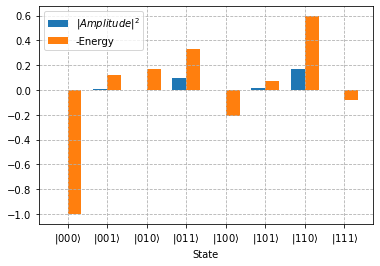

In [8]:
probabilities = cost_function.get_wavefunction(standard_params.raw()).probabilities()
energies = np.diag(ham_matrix)

plot_amplitudes(probabilities, energies)

Now this doesn't look super bad. Clearly, most of the probability goes to the two states of lowest energy $\left|011\right>$ and $\left|110\right>$. This also finishes the main part of the notebook, in the following section we will only give a short outlook into what is possible with different parametrizations. As indiciated in the previous text we go into a lot more detail about parametrizations, cost functions and the convenience functions provided by `utilities.py` in the following Notebooks.

<a id='outlook'></a>
---------------------
## Outlook: Playing with the parameters


In [9]:
betas          = [0.1, 0.6, 0.8]
gammas_singles = [0.4, 0.5, 0.6]
gammas_pairs   = [0.1, 0.3, 0.5]
parameters = (betas, gammas_singles, gammas_pairs)

standard_params_p3 = StandardParams([hamiltonian,3],parameters)

In [10]:
sim = WavefunctionSimulator()

cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=standard_params_p3,
                                        sim=sim,
                                        scalar_cost_function=True,
                                        nshots=0)

res = minimize(cost_function, standard_params_p3.raw(), tol=1e-3,
                      options={"maxiter": 500}, method="Cobyla")
res

     fun: -1.2792999082283594
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 225
  status: 1
 success: True
       x: array([0.54837668, 0.43905085, 0.3163407 , 0.52762594, 0.90690141,
       1.1176764 ])

This is better, but still not the actual ground state. Since we don't seem to be doing very well with `StandardParams`, let's try the `ExtendedParams` parametrisation instead.

In [11]:
extended_params_p3 = ExtendedParams.linear_ramp_from_hamiltonian(hamiltonian, n_steps=3)

cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=extended_params_p3,
                                        sim=sim,
                                        scalar_cost_function=True,
                                        nshots=0)

res = minimize(cost_function, extended_params_p3.raw(), tol=1e-3,
                      options={"maxiter": 500}, method="Cobyla")
res

     fun: -1.7027399171405662
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 500
  status: 2
 success: False
       x: array([ 1.84030115,  0.76415088,  1.4940298 ,  0.54316344,  0.09387112,
        0.36230143,  0.00807827,  0.04683236,  0.47404184,  1.87792982,
        1.03825615,  0.04020408,  1.18729058,  0.19077649,  1.89766998,
        0.32366629,  1.8818648 ,  0.14366302,  0.06541118, -0.15807758,
        0.01375462,  0.84984759,  0.17237512,  0.09283079,  0.67983022,
        0.69662693,  0.52378401])

Clearly now we have found a much better ground state energy. The result attribute `x` is a list of the optimal circuit parameters that have been found. We can disentangle this into the `betas` and `gammas` of our QAOA parameterisation by using the `update_from_raw()` method:

In [12]:
extended_params_p3.update_from_raw(res['x'])
extended_params_p3

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0, 1, 2]
	qubits_pairs: [[0, 1], [0, 2], [1, 2]]
Parameters:
	betas: [[1.84030115 0.76415088 1.4940298 ], [0.54316344 0.09387112 0.36230143], [0.00807827 0.04683236 0.47404184]]
	gammas_singles: [[1.87792982 1.03825615 0.04020408], [1.18729058 0.19077649 1.89766998], [0.32366629 1.8818648  0.14366302]]
	gammas_pairs: [[ 0.06541118 -0.15807758  0.01375462], [ 0.84984759  0.17237512  0.09283079], [ 0.67983022  0.69662693  0.52378401]]

Now that we have the optimal angles, we can prepare the corresponding state and sample from it to obtain the most probable bitstring. 

In this notebook we are using the wavefunction simulator, which allows us to 'cheat' and easily obtain any observable quantity without the need to sample. We use the `get_wavefunction` method of the `cost_function` to obtain the wavefunction, then compute the corresponding probabilities, and plot a bar graph of the outcomes:

In [13]:
opt_wfn = cost_function.get_wavefunction(res.x)
print(opt_wfn)

(0.0059135402+0.0077248702j)|000> + (-0.0015854429-0.002162218j)|001> + (0.0003232891-0.000907545j)|010> + (0.0084391986-0.0068893225j)|011> + (0.0050036803-0.0001815396j)|100> + (-0.0078923198-0.0007587146j)|101> + (0.9331726395-0.358988764j)|110> + (0.0011660097+0.002270504j)|111>


In [14]:
probs = opt_wfn.probabilities()
probs

array([9.46435769e-05, 7.18881600e-06, 9.28153750e-07, 1.18682837e-04,
       2.50697728e-05, 6.28643591e-05, 9.99684108e-01, 6.51476685e-06])

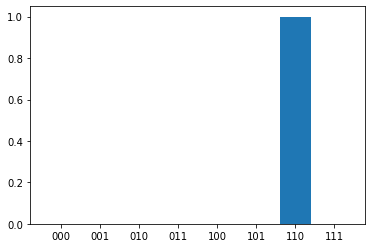

In [15]:
labels = ["{0:03b}".format(i) for i in range(8)]
plt.bar(range(8),probs)
plt.xticks(range(8), labels);

The QAOA has determined that the bitstring 110 (6 in decimal) is the minimum energy solution with essentially unit probability. Let's check this is consistent with the real answer:

In [16]:
np.linalg.eig(ham_matrix)

(array([ 2.86390016+0.j, -0.33618452+0.j, -0.48516548+0.j, -0.95056648+0.j,
         0.59958035+0.j, -0.20989701+0.j, -1.70343667+0.j,  0.22176964+0.j]),
 array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]))

The lowest energy solution does indeed correspond to the eigenvector $(0,0,0,0,0,0,1,0)$, i.e. the $|110\rangle$ component. Suppose that we return to the original Hamiltonian, but instead we remove the single-qubit bias term on qubit 0. Let's run the computation again and see what result we find.

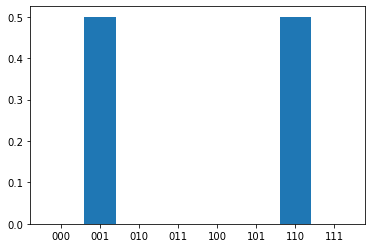

In [17]:
term1 = PauliTerm("Z", 0, 0.7) * PauliTerm("Z", 1)
term2 = PauliTerm("Z", 0, 1.2) * PauliTerm("Z", 2)

hamiltonian_unbiased = PauliSum([term1, term2])
n_steps = 2

params_unbiased = ExtendedParams.linear_ramp_from_hamiltonian(hamiltonian_unbiased,n_steps)

cost_function_unbiased = QAOACostFunctionOnWFSim(hamiltonian_unbiased,
                                                 params=params_unbiased,
                                                 sim=sim,
                                                 nshots=0)

res_unbiased = minimize(cost_function_unbiased, params_unbiased.raw(), tol=1e-3, options={"maxiter":500})

opt_wfn_unbiased = cost_function_unbiased.get_wavefunction(res_unbiased.x)
probs_unbiased = opt_wfn_unbiased.probabilities()

labels = ["{0:03b}".format(i) for i in range(8)]
plt.bar(range(8),probs_unbiased)
plt.xticks(range(8), labels);

Now the probabilities are completely symmetric under a bit flip on all qubits - there is no bias term in the Hamiltonian to force a given qubit into state $|0\rangle$ or $|1\rangle$, and the eigenspectrum of the cost function Hamiltonian is "doubly degenerate", i.e. the energy eigenstates fall into pairs, where the corresponding eigenstates are related to one another by a bit flip on all qubits. 